https://docs.google.com/spreadsheets/d/1DPOARxetaHGSa1gb13VOzjreN6Cnls2Ba4RfH9mlVhI/edit?usp=sharing

In the link above are documented a few of the trials executed.

In [1]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

The below code helps with GPU memory management.

In [2]:
# tf.test.is_gpu_available()
# Avoid OOM (out of memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


## Data sets 

In [4]:
imageSize=300
IMG_SHAPE = (imageSize, imageSize, 3)
batchSize=16

In [8]:
import tf_clahe
# clipLimit=2.0, tileGridSize=(8,8
# tile_grid_size=(4, 4), clip_limit=3.0
@tf.function(experimental_compile=True)  # Enable XLA
def fast_clahe(img):
    return tf_clahe.clahe(img,tile_grid_size=(5, 5), clip_limit=2.0,gpu_optimized=True)

In [4]:

from skimage.util import crop
from skimage import exposure

from skimage.color import rgb2gray , gray2rgb 
def data_augment(image):

    # image = cv2.GaussianBlur(image, (5, 5), 0)
    image = tf.image.central_crop(
    image, 0.8
)

    
    image = tf.image.adjust_contrast(
    image, 2
)
    # if image.dtype != np.uint8:
    #     image = (image * 255).astype(np.uint8)
    # # image = exposure.equalize_hist(image)
    # image = cv2.equalizeHist(image)
   
    # image = fast_clahe(image)
    image = tf.image.resize(
    image,
    (imageSize,imageSize),
    preserve_aspect_ratio=True,
 
)
   
    
    # tf.image.adjust_brightness(image,-0.5)
    return image

The below code cuts images around the lungs

In [ ]:
from PIL import Image
import pandas as pd
from skimage import filters
from sklearn.model_selection import train_test_split
import glob

from sklearn.model_selection import train_test_split

# Split the data into train and validation sets

traindf=pd.read_csv('./dataFull/dp/labels_train.csv',dtype=str)
# traindf50=pd.read_csv('./dataFull/dp/labels_train_over50kb2.csv',dtype=str)
# traindf50=pd.read_csv('./dataFull/dp/labels_cropped.csv',dtype=str)
# Balanced_traindf=pd.read_csv('./dataFull/dp/BALANCED_labels_train.csv',dtype=str)
# traindf_augmented=pd.read_csv('./augmented_data.csv',dtype=str)
# TRY THIS:

# df_np = traindf[(traindf.class_id == '0') | (traindf.class_id == '1') | (traindf.class_id == '2')]
# df_np['class_id'] = df_np['class_id'].replace({'0': '0', '1': '1','2':'1'})

# # Extract data with only two classes (viral vs bacterial pneumonia)
# df_vp = traindf[(traindf.class_id == '1') | (traindf.class_id == '2')]
# df_vp['class_id'] = df_vp['class_id'].replace({'1': '0', '2': '1'})

# train_dfVp, val_dfVp = train_test_split(df_vp, test_size=0.2, stratify=df_vp['class_id'],shuffle=True)

train_df, val_df = train_test_split(traindf, test_size=0.2, stratify=traindf['class_id'],shuffle=True)

def preprocess(x):
    # Apply median filter
    x = tf.image.central_crop(
    x, 0.8
)
    x = tf.image.resize(
    x,
    (imageSize,imageSize),
    preserve_aspect_ratio=True,
 
)

    x = filters.median(x)
    # Apply Gaussian filter
    x = filters.gaussian(x, sigma=1)
    # Apply Sobel filter
    # x = filters.sobel(x)
    # Apply Otsu thresholding
    # x = filters.threshold_otsu(x)
    return x

imageSize=256
IMG_SHAPE = (imageSize, imageSize, 3)
batchSize=16


def hist_equalize(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def adjustContrast(image):
    # image = hist_equalize(image)
    return tf.image.adjust_contrast( image, 2)
# 

def non_local_means(image, h=0.1):
    
    # denoised_image = cv2.medianBlur(image, 3)
    image = tf.image.adjust_contrast(image, 3)
    # image = fast_clahe(image)
    # iamge =cv2.GaussianBlur(image, (5, 5), 0)
    
   
   
  
    return image



def image_Gamma(img):
    gamma = 0.5

    # Apply gamma correction
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    img_gamma = cv2.LUT(img, lookUpTable)
    return img_gamma


from PIL import Image
import numpy as np
import os

image_dir = "./dataFull/dp/train_images/train_images_Cropped2/"

# Load all the images into memory as NumPy arrays
images = []
filenames = []



datagen = ImageDataGenerator(   
                                rescale = 1./255,
                                shear_range = 0.1,
                                zoom_range = 0.15,
                                rotation_range = 10,
                                # # # # # brightness_range = [0.5,1.5],
                                width_shift_range = 0.1,
                                # # # width_shift_range=[-100,100],
                                height_shift_range = 0.1,
                                # rotation_range=15,
                                # # fill_mode='reflect',
                                # fill_mode='nearest',
                                # fill_mode='constant',
                                # width_shift_range=0.20,
                                # shear_range=0.1
                                # zoom_range=[0.5,1.0],
                                # zoom_range=0.25,
                                # samplewise_center=True,
                                # samplewise_std_normalization=True,
                                # validation_split=0.2,
                                # horizontal_flip=True,
                                # preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape)
                                # vertical_flip=True,
                                # preprocessing_function = AHE
                                # preprocessing_function = tf.keras.applications.densenet.preprocess_input,
                                # preprocessing_function = tf.keras.applications.xception.preprocess_input,
                                # preprocessing_function = tf.keras.applications.resnet50.preprocess_input,

                                # preprocessing_function = tf.keras.applications.vgg19.preprocess_input
                                # preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input
                                # preprocessing_function=fast_clahe
                                # preprocessing_function = gradient_filter,
                                # preprocessing_function = data_augment
                                # preprocessing_function = image_Canny
                                # preprocessing_function = image_Gamma
                                # preprocessing_function = non_local_means
                                # preprocessing_function = preprocess
                                # preprocessing_function = crop_lungs
                                # preprocessing_function=gaussian_blur
                                # preprocessing_function = data_augmentNew
                            )

validgen = ImageDataGenerator (
                                rescale= 1./255,
                                # validation_split=0.2,
                                # fill_mode='reflect',
                                # preprocessing_function = adjustContrast
                                # preprocessing_function = non_local_means 
                                # preprocessing_function = image_Gamma
                                # preprocessing_function = gradient_filter,
                                # samplewise_center=True,
                                # samplewise_std_normalization=True,
                                # preprocessing_function=fast_clahe
                                # preprocessing_function = tf.keras.applications.densenet.preprocess_input,
                                # preprocessing_function = tf.keras.applications.xception.preprocess_input,
                                # preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
                                # preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                                # preprocessing_function = data_augment
                                # preprocessing_function = preprocess
                                # preprocessing_function = crop_lungs
                                # preprocessing_function=gaussian_blur
                                # preprocessing_function = data_augmentNew
                                )
# 
# test_datagen = ImageDataGenerator(
                                # rescale = 1./255, 
#                                 rotation_range=20,
#                                 width_shift_range=0.1,
#                                 shear_range=0.1,
#                                 zoom_range=0.1,
#                                 samplewise_center=True,
#                                 samplewise_std_normalization=True,
#                                 validation_split=0.2,
#                                 preprocessing_function = data_augment
# )

# train_files = glob.glob('./dataFull/dp/train_images/train_images/*.jpg')
# train_data = []
# for file in train_files:
#     image = cv2.imread(file)
#     train_data.append(image)
# train_data = np.array(train_data)

# for i in train_files:
#     image = Image.open(format(i))
#     # Resize the image to a common size
#     image = image.resize((imageSize, imageSize))
#     train_data.append(np.array(image))

# datagen.fit(train_data)
# print(train_data.shape)

# gen_train = datagen.flow(images_train, classes_train, batch_size=10)
# gen_val = datagen.flow(images_train, classes_train, batch_size=10)
# path =  './data/detect-pneumonia-fall-2022-23/train_images/Augmented/'
# # save_path = './data/detect-pneumonia-fall-2022-23/train_images/Class 2/augmented'

# # batch_size=50
# # num_aug_images_wanted = 5000

# train_generator2 = datagen.flow_from_directory(
#                                             path,
#                                             # save_to_dir=save_path,
#                                             # save_format='jpg',
#                                             # save_prefix="aug_",
#                                             # color_mode="grayscale",
#                                             seed=47,
#                                             shuffle=False,
#                                             subset="training",
#                                             target_size=(224,224),
#                                             class_mode="categorical",
#                                             batch_size=batchSize
#                                             )

# validation_generator2 = validgen.flow_from_directory(
#                                             path,
#                                             # save_to_dir=save_path,
#                                             # save_format='jpg',
#                                             # save_prefix="aug_",
#                                             # color_mode="grayscale",
#                                             seed=47,
#                                             subset="validation",
#                                             shuffle=False,
#                                             target_size=(224,224),
#                                             class_mode="categorical",
#                                             batch_size=batchSize
#                                             )
        



# num_files = len(os.listdir(img_dir))
# num_batches = int(np.ceil((num_aug_images_wanted)/batch_size))

#     # run the generator and create augmented images
# for i in range(0,num_batches):

#     imgs, labels = next(augment_class0)


train_generator=datagen.flow_from_dataframe(
# dataframe=traindf,
dataframe=train_df,
# dataframe=Balanced_traindf,
# dataframe=df_np,
# dataframe=traindf_augmented,
# color_mode="grayscale",
# color_mode="rgb",
# directory="./dataFull/dp/train_images/train_images/",
directory="./dataFull/dp/train_images/train_images_Cropped2/",
# directory="./dataFull/dp/train_images/train_images_edited1/",
# save_to_dir="./dataFull/dp/train_images/train_images/augmented/",
# save_to_dir="./dataFull/dp/train_images/train_images_edited1/augmented/",
# save_format="jpg",
# save_prefix="aug_",
x_col="file_name",
y_col="class_id",
# classes=['0'],
# subset="training",
batch_size=batchSize,
seed=47,
shuffle=False,
class_mode="categorical",
# class_mode="binary",
target_size=(imageSize,imageSize)
# target_size=imageSize
)




validation_generator= validgen.flow_from_dataframe(
# dataframe=traindf,
dataframe=val_df,
# dataframe=Balanced_traindf,
# dataframe=df_np,
# dataframe=traindf_augmented,
# directory="./dataFull/dp/train_images/train_images/",
directory="./dataFull/dp/train_images/train_images_Cropped2/",
# directory="./dataFull/dp/train_images/train_images_edited1/",
x_col="file_name",
y_col="class_id",
# color_mode="grayscale",
# classes=['1','2'],
# classes=['0'],
# color_mode="rgb",
# subset="validation",
batch_size=batchSize,
seed=47,
shuffle=False,
class_mode="categorical",
# class_mode="binary",
target_size=(imageSize,imageSize)
# target_size=imageSize

)



Visualization of images to check if the augmentations , settings are working as expected before moving further.

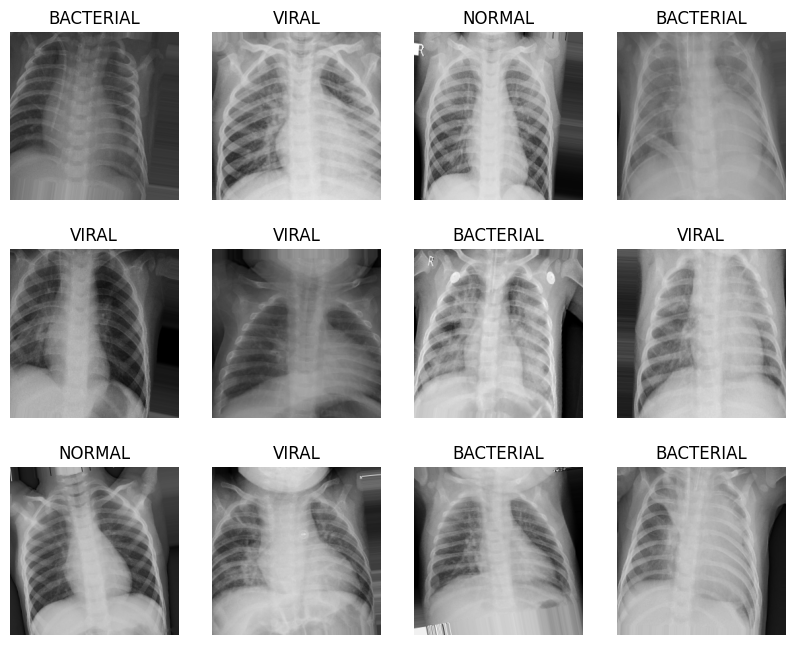

In [4]:
labels = ['NORMAL', 'BACTERIAL', 'VIRAL']

sample_data = train_generator.__getitem__(1)[0] 
sample_label = train_generator.__getitem__(1)[1] 


plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])
# class_labels = np.argmax(y_train_augmented, axis=1)
# for i in range(9):
#     plt.subplot(330 + 1 + i)
#     plt.imshow(x_train_augmented[i])
#     plt.title(f"Class {labels[class_labels[i]]}")

# plt.show()


In [ ]:
sample_data = validation_generator.__getitem__(0)[0] 
sample_label = validation_generator.__getitem__(0)[1] 



plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

# class_labels = np.argmax(targets_train, axis=1)
# for i in range(9):
#     plt.subplot(330 + 1 + i)
#     plt.imshow(data_train[i])
#     plt.title(f"Class {labels[class_labels[i]]}")

# plt.show()

## Models

### Helpers

Some codes to print diagrams , gradcams 

In [5]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [6]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [7]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((imageSize, imageSize))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [9]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

Definition of some callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
import math
import datetime
from keras.callbacks import TensorBoard
logdir = 'logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = EarlyStopping(monitor='val_loss', mode='min', patience=7,verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.5, min_lr=0.00000001)


value = datetime.datetime.now()
tempz = value.strftime('%Y-%m-%d.%H.%M.%S')
print(tempz)
bst_model_path = './models/bestRuns/' + tempz + 'Val_Loss.h5'
bst_model_path2 = './models/bestRuns/' + tempz + 'Val_Acc.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True,monitor='val_loss',
    mode='min' , verbose=1)
model_checkpoint2 = ModelCheckpoint(bst_model_path2, save_best_only=True, save_weights_only=True,monitor='val_accuracy',
    mode='max', verbose=1)
callbacks_list = [
    learning_rate_reduction,
    tensorboard_callback,
    model_checkpoint,
    model_checkpoint2,
    # early,
    # lrate,
    # history
    ]

Classweights to address class imbalance

In [9]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(train_generator.classes)                          
# counter = Counter(validation_generator.classes)                          
# counter = Counter(train_generator2.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.8246687054026502, 1: 1.0, 2: 1.8530020703933747}

In [327]:
counter = Counter(validation_generator.classes)
counter.values()    

dict_values([981, 995, 965])

Below are some of the models used, code can be adjusted to use any model and even build our own (e.g. by using Sequential)

In [ ]:
# img_shape=(imageSize[0], imageSize[1], 3)
# imageSize = 224
pretrained_xcept = tf.keras.applications.Xception(input_shape=(imageSize, imageSize, 3), weights='imagenet', include_top=False)
# pretrained_xcept = tf.keras.applications.Xception(input_shape=(img_shape), weights='imagenet', include_top=False)

for layer in pretrained_xcept.layers:
  layer.trainable = False

x1 = pretrained_xcept.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)

x1 = tf.keras.layers.Dense(32, activation="relu", name="dense_head")(x1)

x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)

sgd = SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=True)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

for layer in pretrained_xcept.layers[-4:]:
    layer.trainable=True
model_xcept = Model(inputs=pretrained_xcept.input, outputs=model_out)

model_xcept.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
# model_xcept.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
# model_xcept.compile(optimizer=tf.keras.optimizers.Nadam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0),loss="categorical_crossentropy",metrics=['accuracy'])
# loss_weights=[1.0, 0.1 * (1. / 0.9)]

model_xcept.summary()

In [ ]:
from vit_keras import vit, utils
model_vit = vit.vit_b16(
    image_size=imageSize,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=3
)

In [ ]:
import tensorflow_addons as tfa
model = tf.keras.Sequential([
        model_vit,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

In [19]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, 
            #   loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

In [ ]:
model_effB3.summary()

In [ ]:
from keras import regularizers
from sklearn.ensemble import AdaBoostClassifier

pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(imageSize, imageSize, 3), weights='imagenet', include_top=False)


for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output

x1 = tf.keras.layers.GlobalAveragePooling2D(name="averagepooling2d_head")(x1)

x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)

x1 = tf.keras.layers.Dense(64,
                           
                              activation="relu", 
                              name="dense_head")(x1)

x1 = tf.keras.layers.Dropout(0.2, name="dropout_head")(x1)

sgd = SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=True)


opt = tf.keras.optimizers.Adamax(lr=0.0001, decay=1e-5)

model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)
for layer in pretrained_densenet.layers[-16:]:
    layer.trainable=True
model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)

model_densenet.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])


# model_densenet.compile(optimizer=tf.keras.optimizers.Nadam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0),loss=[focal_loss(alpha=.25, gamma=2)],metrics=['accuracy'])
# model_densenet.compile(optimizer=tf.keras.optimizers.Nadam(lr = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0),loss="categorical_crossentropy",metrics=['accuracy'])

# # X_train = model_densenet.predict(train_generator)
# X_test = model_densenet.predict(validation_generator)
# # y = t.reshape(-1,1)
# # Create an AdaBoostClassifier object
# ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
# # print(X_test)
# # Fit the model
# ada.fit(X_test, y_test2)
model_densenet.summary()

SWIN

Image Transformers are the latest developemnt in image classification.

In [10]:
from keras import layers
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [11]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [12]:
from keras import layers
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [13]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [18]:
input_shape = (imageSize,imageSize,3)
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = imageSize  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 16
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [19]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3, activation="softmax")(x)

In [22]:
import tensorflow_addons as tfa
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size=batch_size,
    epochs=35,
    callbacks=callbacks_list
)

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd

def align_and_crop(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to binarize it
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours in the binary image
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Find the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

def process_folder(src_folder, dst_folder, csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Iterate over all rows in the CSV file
    for index, row in df.iterrows():
        # Load the image
        file = row["file_name"]
        image = cv2.imread(os.path.join(src_folder, file))

        # Align and crop the image
        cropped_image = align_and_crop(image)

        # Save the cropped image
        cropped_file = "cropped_" + file
        cv2.imwrite(os.path.join(dst_folder, file), cropped_image)

        # Update the CSV file with the new file name
        df.at[index, "file_name"] = cropped_file

    # Save the updated CSV file
    newCsv = "labels_cropped"
    df.to_csv("./dataFull/dp/labels_cropped", index=False)

# Define the source folder, destination folder, and CSV file
src_folder = "./dataFull/dp/train_images/train_images/"
dst_folder = "./dataFull/dp/train_images/train_images_Cropped2/"
csv_file = "./dataFull/dp/labels_train.csv"

# Process the folder
process_folder(src_folder, dst_folder, csv_file)


In [70]:
from keras.layers import BatchNormalization,Dropout,Dense
from keras.optimizers import Nadam

# base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# base_model = tf.keras.applications.DenseNet121(input_shape=(imageSize,imageSize,3), include_top=False,weights='imagenet')
base_model = tf.keras.applications.VGG19(input_shape=(imageSize,imageSize,3), include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x= Dropout(0.5)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)

x= Dense(1024,activation='relu')(x) 
x = tf.keras.layers.Dense(3, activation='softmax')(x)
effV2M = tf.keras.models.Model(inputs=base_model.input, outputs=x)
# effV2M = build_transfer_model(base_model,dropout=0.4,conv_nodes=128,dense_node =512,learn_rate=0.001,metric=['accuracy'])
# for layer in effV2M.layers[:-8]:
#     layer.trainable=False

# with 16 -> 0.8426 Validation
# with 32 -> ?????? Validation
# with 20 we got 0.38 Val ( while running )
# with 16 we got the best submitted :D
for layer in effV2M.layers[-12:]:
    layer.trainable=True
effV2M.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# effV2M.compile(optimizer=Nadam(learning_rate = 0.001,beta_1 = 0.9,beta_2=0.999,clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
effV2M.summary()

In [14]:
model.load_weights("./brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [15]:
x2 = model.output
x2 = tf.keras.layers.Dense(512,activation='relu')(x2)
x2 = tf.keras.layers.Dense(3, activation='softmax')(x2)
final_model = Model(model.input,outputs=x2)

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.summary(
)

Below is code of the "Darknet-19" model

In [15]:
import numpy as np
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential


sgd = SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=True)

# Create the model
modelWtf = Sequential()

# Add Convolutional Layers
modelWtf.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(imageSize,imageSize,3)))
modelWtf.add(MaxPooling2D(pool_size=(2,2)))
modelWtf.add(Conv2D(64, (3,3), padding='same', activation='relu'))
modelWtf.add(MaxPooling2D(pool_size=(2,2)))
modelWtf.add(Conv2D(128, (3,3), padding='same', activation='relu'))
modelWtf.add(MaxPooling2D(pool_size=(2,2)))
modelWtf.add(Conv2D(256, (3,3), padding='same', activation='relu'))
modelWtf.add(MaxPooling2D(pool_size=(2,2)))
modelWtf.add(Conv2D(512, (3,3), padding='same', activation='relu'))
modelWtf.add(MaxPooling2D(pool_size=(2,2)))
modelWtf.add(Conv2D(1024, (3,3), padding='same', activation='relu'))
modelWtf.add(Conv2D(1024, (3,3), padding='same', activation='relu'))
modelWtf.add(Conv2D(1024, (3,3), padding='same', activation='relu'))

# Flatten the output and add a fully connected layer
modelWtf.add(Flatten())
modelWtf.add(Dense(256, activation='relu'))
modelWtf.add(Dense(3, activation='softmax'))

# Compile the model
modelWtf.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [ ]:
modelWtf.summary()

Training of the model

In [ ]:

# TRY STEPS PER EPOCH 500 or something -> to try and generate more images and lets see what happens!
history_densenet = model_densenet.fit(train_generator, validation_data=validation_generator, class_weight=class_weights,callbacks=callbacks_list, epochs=35) 


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
model1 = KerasClassifier(build_fn=model_densenet, epochs=10, batch_size=32, verbose=0)
model2 = KerasClassifier(build_fn=model_xcept, epochs=10, batch_size=32, verbose=0)
model3 = KerasClassifier(build_fn=model_inRes, epochs=10, batch_size=32, verbose=0)

# Create an ensemble model using a voting classifier ( other voting = hard)
ensemble_model = VotingClassifier(estimators=[('m1', model1), ('m2', model2), ('m3', model3)], voting='soft')

In [ ]:
enseble_history = ensemble_model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks_list, epochs=35)   
# history_densenet = model_densenet.fit_generator(training_set, validation_data=validation_generator, callbacks=[lr_reduce, es_callback], epochs=30)   

Κωδικας για να φορτώσουμε αποθηκευμένα βαρη (απο τα callbacks)

In [47]:
model_densenet.load_weights('./models/bestRuns/2023-02-10.15.06.37Val_Loss.h5')

Κώδικας για να κανει predict στις εικονες του test και μετα δημιουργια του csv για να ανέβει στο kaggle

In [ ]:
from keras.preprocessing import image
from tensorflow.keras.utils import load_img , img_to_array 
from skimage.color import rgb2gray , gray2rgb 

images = []
folder_path = './dataFull/dp/test_images/test_images/'
finalRes = []
i = 0
for img in os.listdir(folder_path):
    imgName = img
    img = os.path.join(folder_path, img)
    img = load_img(img, target_size=(imageSize, imageSize))
    
    img = img_to_array(img)/255.0
    # img = data_augment(img)
    # img = rgb2gray(img)
    # img = tf.keras.applications.resnet50.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    # tempRes = model.predict(img)
    tempRes = model_densenet.predict(img)
    maxIdx = np.argmax(tempRes)
    print(tempRes)
    # print(maxIdx)
    finalRes.append([imgName,maxIdx])


In [57]:
res = pd.DataFrame(finalRes, columns=['file_name','class_id']).to_csv('result.csv',index=False)

C:\conda_temp\ipykernel_16820\4283597964.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


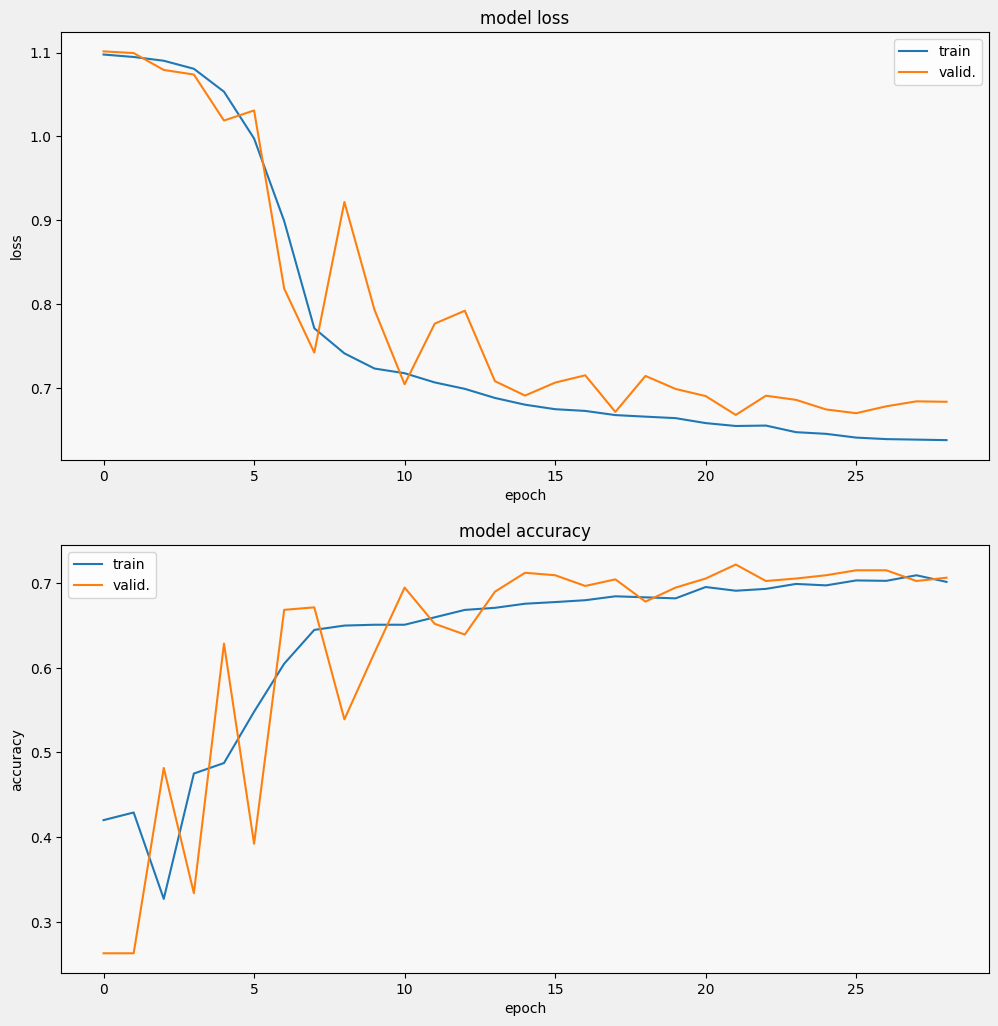

In [18]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

## Prediction Sample

In [49]:
last_conv_layer_name = "conv5_block32_concat"
# last_conv_layer_name = "conv5_block32_2_conv"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

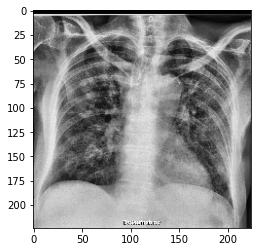

In [44]:
# test image
file_path =  '/test/COVID19/COVID19(164).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [50]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

NameError: name 'test_image' is not defined

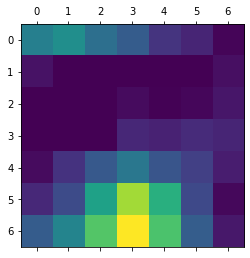

In [46]:
plt.matshow(heatmap)
plt.show()

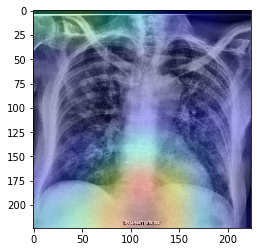

In [47]:
s_img = superimposed_img(test_image[0], heatmap)
plt.imshow(s_img)

In [51]:
# sample_data = validation_generator.__getitem__(0)[0] 
# sample_label = validation_generator.__getitem__(0)[1] 
sample_data = validation_generator.__getitem__(0)[0] 
sample_label = validation_generator.__getitem__(0)[1] 
# sample_data = validation_generator2.__getitem__(0)[0] 
# sample_label = validation_generator2.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)
    

NameError: name 'validation_generator' is not defined

Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# y_pred = model_densenet.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)
# y_pred = model_xcept.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)
# y_pred = model_xcept.predict(data_test,targets_test , verbose=1)
# y_pred = np.argmax(targets_test, axis=1)
# # y_pred = np.argmax(y_pred, axis=1)
# # y_pred = np.round(y_pred)
# y_true = targets_test.classes
# y_true = validation_generator.classes
# Make predictions on the test data
predictions = model_densenet.predict(data_test)

# Convert predictions to class labels
predictions_class = np.argmax(predictions, axis=1)

# Convert targets to class labels
targets_class = np.argmax(targets_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true=targets_class, y_pred=predictions_class)


# cm = confusion_matrix(y_true, y_pred)
print(cm)

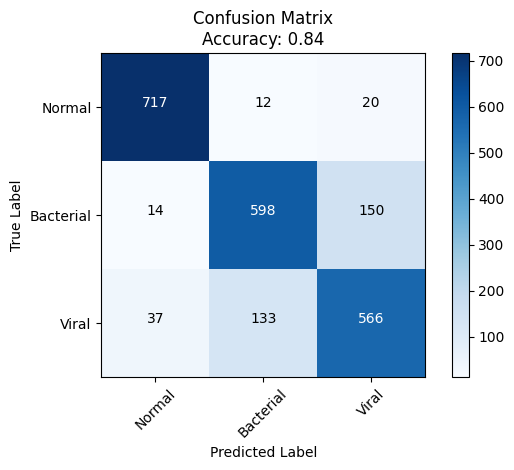

In [29]:
import matplotlib.pyplot as plt
import itertools

# Confusion matrix
# cm = np.array([[55, 20, 15], [10, 50, 40], [5, 25, 70]])

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)

accuracy = np.sum(np.diag(cm)) / np.sum(cm)

# Add title and axis labels
plt.title('Confusion Matrix\nAccuracy: {:.2f}'.format(accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')



# Add appropriate axis scales
class_names = ['Normal', 'Bacterial','Viral']
# class_names = ['Bacterial', 'Viral']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Add a legend
plt.colorbar()
plt.tight_layout()

# Display the plot
plt.show()